In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

References:
https://www.activestate.com/resources/quick-reads/how-to-install-keras-and-tensorflow/

https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-lstm-rnn-in-tensorflow/

Data Loading, Preparing and Scaling
Here we are using a dataset of monthly illegal dumping using LSTM. You can download dataset from here.

We load the dataset of monthly illegal dumping frequency. The "Date" column is converted to datetime format for time series analysis.
We scale the data to a range of [0, 1] using MinMaxScaler to help the model train more effectively.

In [12]:
df = pd.read_csv('../data/daily_counts_illegal_dumping_hp.csv')

In [13]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
frequency = df['freq'].astype(float).values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(frequency)

Here we generate sequences of input data and split the dataset into training and testing sets.

We use a sliding window of 12 months (1 year) of past data to predict the next month's dumping frequency.
The dataset is split into training and testing sets and reshaped to match the LSTM input shape.
We split 80% data for training and 20% for testing purposes.

In [20]:
window_size = 12
X = []
y = []
target_dates = df.index[window_size:]

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.15, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Building the LSTM Model
This step involves defining and building the LSTM model architecture.

The model consists of two LSTM layers, each with 128 units and a dropout layer after each to prevent overfitting.
The model concludes with a Dense layer to predict a single value (next month's dumping frequency).

In [21]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\rhuntley\OneDrive - Esperanza, Inc\Documents\Code\philly-illegal-dumping\philly-illegal-dumping-forecast\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.15)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0237 - val_loss: 0.0116
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0236 - val_loss: 0.0113
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0225 - val_loss: 0.0118
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0230 - val_loss: 0.0112
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0225 - val_loss: 0.0112
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0224 - val_loss: 0.0110
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0227 - val_loss: 0.0122
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0226 - val_loss: 0.0125
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0224 - val_loss: 0.0122
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0227 - val_loss: 0.0119
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0225 - val_loss: 0.0140
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

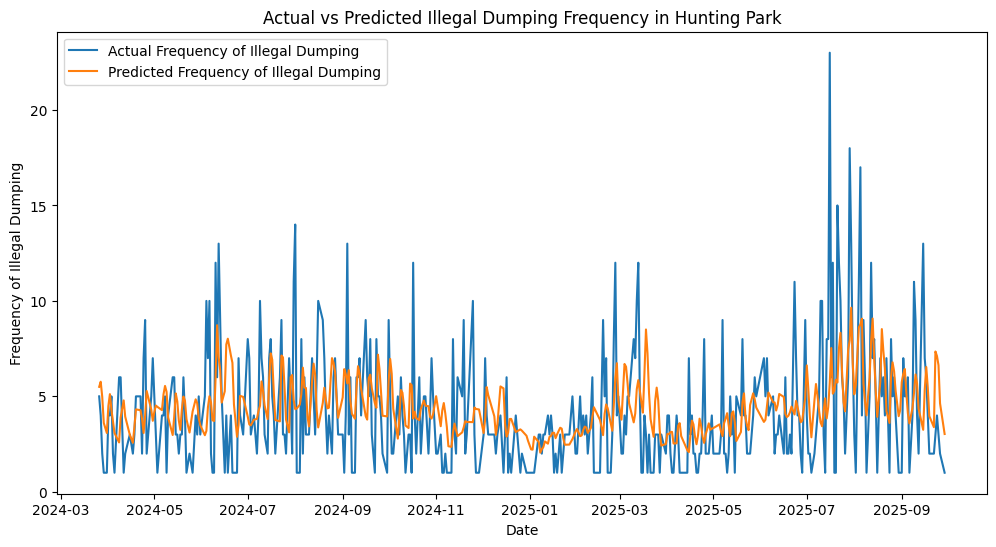

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Frequency of Illegal Dumping')
plt.plot(dates_test, predictions, label='Predicted Frequency of Illegal Dumping')
plt.title('Actual vs Predicted Illegal Dumping Frequency in Hunting Park')
plt.xlabel('Date')
plt.ylabel('Frequency of Illegal Dumping')
plt.legend()
plt.show()